In [6]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.utils import pickle_open
from cohlib.plot import draw_raster_single


In [7]:
def plot_synthetic_data(L, sample_length, C, seed, alpha, fs=1000, start=0):
    T = sample_length/fs
    trange = [0,T]
    data_path = f'saved/synthetic_data/simple_synthetic_nodc_2_{L}_{sample_length}_{C}_{alpha}_{seed}'

    data_load = pickle_open(data_path)

    spikes = data_load['observed']['spikes']

    Gamma = data_load['latent']['Gamma']
    xs = data_load['latent']['xs']
    vs = data_load['latent']['vs']
    zs = data_load['latent']['zs']
    lams = data_load['observed']['lams']

    freqs = data_load['meta']['freqs']

    swap = False
    ls = [0,1,2]
    fig,ax = plt.subplots(6,1,figsize=(12,7), sharex=True)
    ls = [l + start for l in ls]
    title_size = 16
    label_size = 14
    x = np.arange(0, sample_length) / 1000
    # for i in range(start,start+3):
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for i, l in enumerate(ls):
    # i = 3
        
        ax[0].plot(x, xs[l,0,:], color=colors[i])
        # ax[0].set_ylim([-1,1])
        ax[0].margins(0)
        ax[0].set_title(r'$x_t^{1, \ell}$  $\ell = (1,2,3)$', size=title_size)
        ax[0].set_ylabel('mV', size = label_size)

        ax[1].plot(x, xs[l,1,:], color=colors[i])
        # ax[1].set_ylim([-1,1])
        ax[1].margins(0)
        ax[1].set_title(r'$x_t^{2, \ell}$  $\ell = (1,2,3)$', size=title_size)
        ax[1].set_ylabel('mV', size = label_size)

        ax[2].plot(x, lams[l,0,:], color=colors[i])
        ax[2].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
        ax[2].margins(0)
        ax[2].set_ylabel('Intensity', size = label_size)

        ax[3].plot(x, lams[l,1,:], color=colors[i])
        ax[3].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
        ax[3].margins(0)
        ax[3].set_ylabel('Intensity', size = label_size)

    # draw_raster_single(spikes[start,:,:], trange=[0,0.5], region='CPB', override_bg_color='white',ax=ax[3])
    color = colors[0]
    spike_matA = spikes[ls[0],:,0,:]
    spike_matB = spikes[ls[0],:,1,:]
    draw_raster_single(spike_matA, trange=trange, color_name=color, ax=ax[4])
    draw_raster_single(spike_matB, trange=trange, color_name=color, ax=ax[5])
    ax[4].set_title(r'$n_t^{1, c,\ell}$   $c = (1, ..., C)$   $\ell = 1$', size=title_size)
    ax[5].set_title(r'$n_t^{2, c,\ell}$   $c = (1, ..., C)$   $\ell = 1$', size=title_size)
    ax[4].set_ylabel('Spikes A', size = label_size)
    ax[5].set_ylabel('Spikes B', size = label_size)

    ax[5].set_xlabel('Time (sec)', size = label_size)
    plt.xlim([0,sample_length/fs])
    plt.tight_layout()

In [103]:
from cohlib.mvcn import gen_random_mvcn_params, sample_mvcn_time_obs_nodc
from cohlib.alg.transform import construct_real_idft
def construct_latent_and_sample_bcn_mod(sample_length, L, fs, K, val10, val0):
    T = sample_length/fs
    Gamma, freqs = gen_random_mvcn_params(T, fs, K)
    n_freqs = Gamma.shape[0]

    scale_duration_multiplier = sample_length / 1000
    J = n_freqs
    for j in range(J):
        _, eig_vecs = np.linalg.eigh(Gamma[j,:,:])
        mod_vals = np.array([1,1])*scale_duration_multiplier
        # new_mat = eig_vecs @ np.diag(mod_vals) @ eig_vecs.conj().T
        new_mat = eig_vecs @ np.diag(mod_vals) @ eig_vecs.conj().T
        # new_mat = new_mat*(1e-3*scale_duration_multiplier)
        Gamma[j,:,:] = new_mat

    freq_ind = np.ceil(sample_length / 100).astype(int)
    _, eig_vecs = np.linalg.eigh(Gamma[freq_ind,:,:])

    # val1 = 0.5 * sample_length
    # val2 = 0.5 * sample_length 
    val1 = val10
    val2 = val10 
    

    Gamma[freqs==10,0,0] = val1+0*1j
    Gamma[freqs==10,1,1] = val2+0*1j

    # construct high coherence for target freq
    val = np.sqrt(val1)*np.sqrt(val2)
    init = np.abs(Gamma[freqs==10,1,0])
    scale = val/init
    Gamma[freqs==10,1,0] *= scale*0.92
    Gamma[freqs==10,0,1] = Gamma[freqs==10,1,0].conj()

    Gamma[freqs!=10,:,:] *= Gamma[freqs!=10,:,:]*(1/val0)
    # Gamma[freqs!==10,:,:] = Gamma[freqs==10,1,0].conj()


    cutoff_freq = 100
    cutoff_freq_ind = np.where(freqs > cutoff_freq)[0][0]
    Gamma_reduce = Gamma.copy()
    Gamma_reduce[cutoff_freq_ind:,:,:] = 0
    freqs_reduce = freqs

    # Draw observations from mvcn (in time domain) 
    Wv = construct_real_idft(sample_length, freqs.size, fs)
    Wv_reduce = Wv[:,1:]

    xs, vs, zs = sample_mvcn_time_obs_nodc(Gamma_reduce, L, freqs_reduce, Wv_reduce, return_all=True)

    latent = dict(Gamma=Gamma_reduce, xs=xs, vs=vs, zs=zs)
    meta = dict(freqs=freqs, Wv=Wv_reduce)

    return latent, meta

In [91]:
alpha = -3.5
K = 2
L = 25 
C = 1
sample_length = 1000
fs = 1000
latent, meta = construct_latent_and_sample_bcn_mod(sample_length, L, fs, K)

/scratch/252258.1.ood/ipykernel_1345419/3192526711.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10*np.log10(Gamma[:,0,0].real))


(0.0, 50.0)

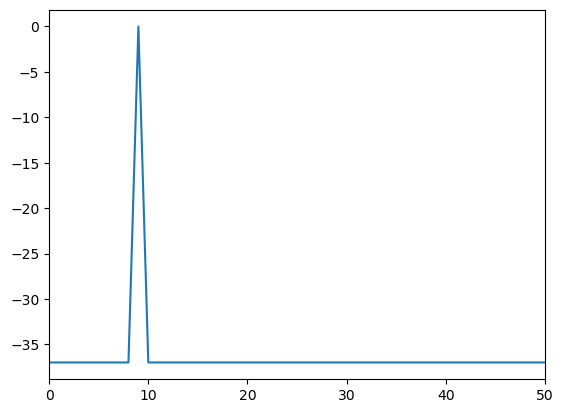

In [92]:
Gamma = latent['Gamma']
plt.plot(10*np.log10(Gamma[:,0,0].real))
plt.xlim([0,50])


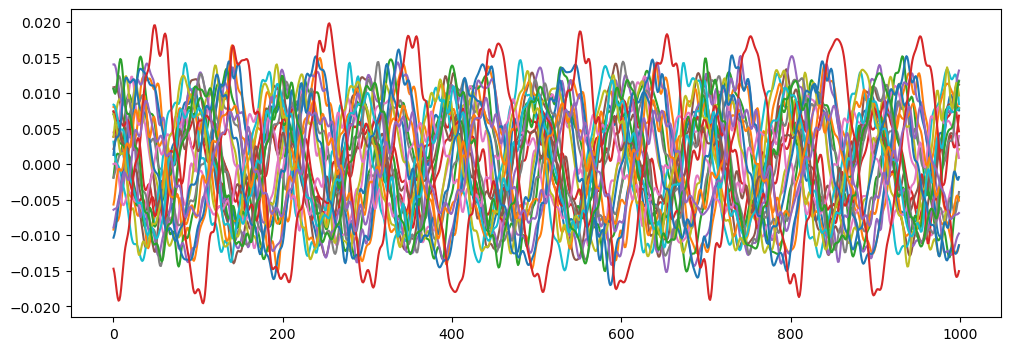

In [93]:
latent.keys()
xs = latent['xs']
fig, ax = plt.subplots(figsize=(12,4))
for l in range(L):
    ax.plot(xs[l,0,:])

In [94]:
np.exp(-3.5)
alphas = np.array([0.04 for k in range(K)])
lams_idlink = alphas[None,:,None] + xs

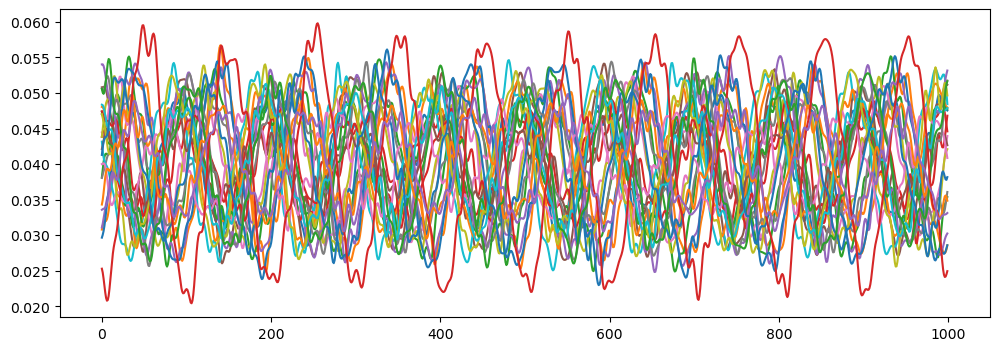

In [95]:
fig, ax = plt.subplots(figsize=(12,4))
for l in range(L):
    ax.plot(lams_idlink[l,0,:])

In [97]:
def sample_spikes_from_xs_poisson(lams, C, group_axis=1):
    sampler = _c_sample_func_poisson(C)
    samples = np.apply_along_axis(sampler, group_axis, lams)
    return samples
def _c_sample_func_poisson(C):
    def func(x):
        reps = np.tile(x, C).reshape(C,-1)
        samples = np.random.poisson(reps)
        return samples
    return func
def cif_alpha_loglink(alphas, xs):
    pre_lam = alphas[None,:,None] + xs
    return np.exp(pre_lam)

In [138]:
Ctemp = 25
alpha = 5  
val10 = 30000
val0 = 1/50
latent, meta = construct_latent_and_sample_bcn_mod(sample_length, L, fs, K, val10, val0)
xs = latent['xs']
alphas = np.array([alpha for k in range(K)])
xs.min()
lams_idlink = alphas[None,:,None] + xs
# spikes_poisson = sample_spikes_from_xs_poisson(lams_idlink, Ctemp)

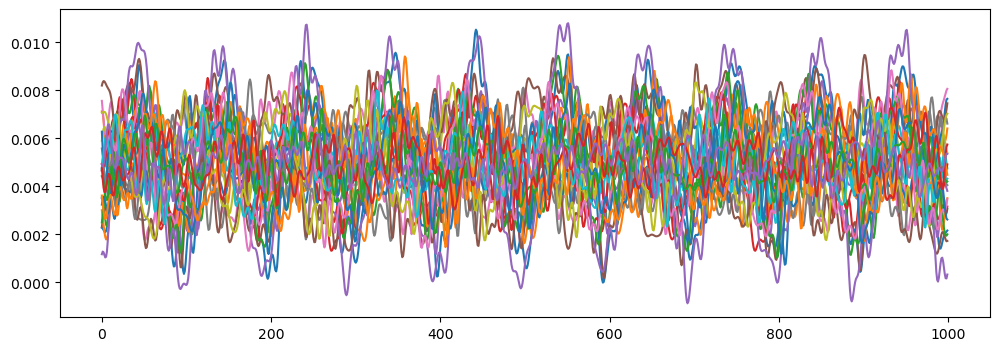

In [140]:
fig, ax = plt.subplots(figsize=(12,4))
for l in range(L):
    # ax.plot(xs[l,0,:])
    ax.plot(lams_idlink[l,0,:]*1e-3)

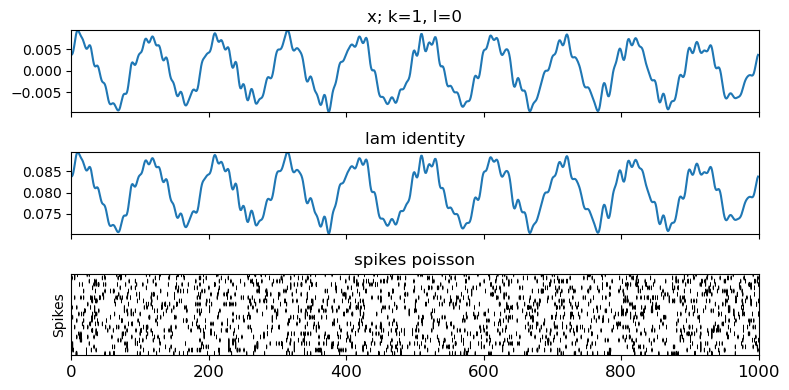

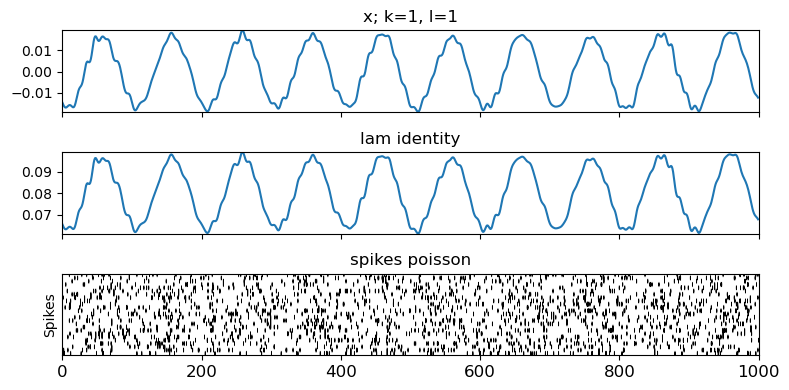

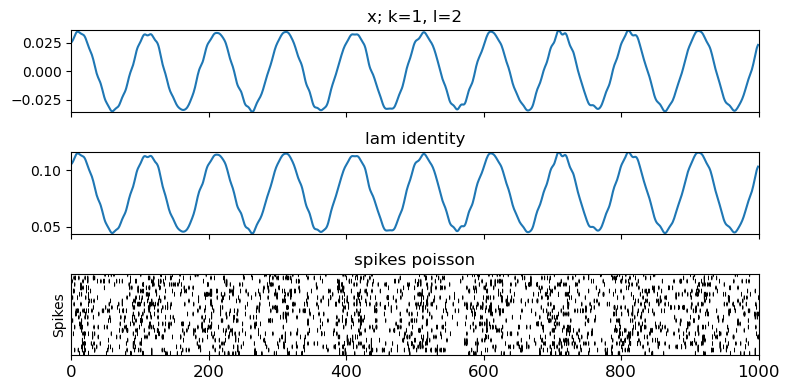

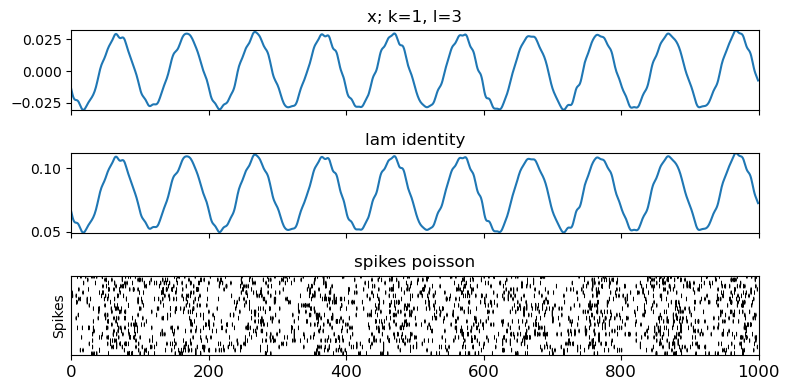

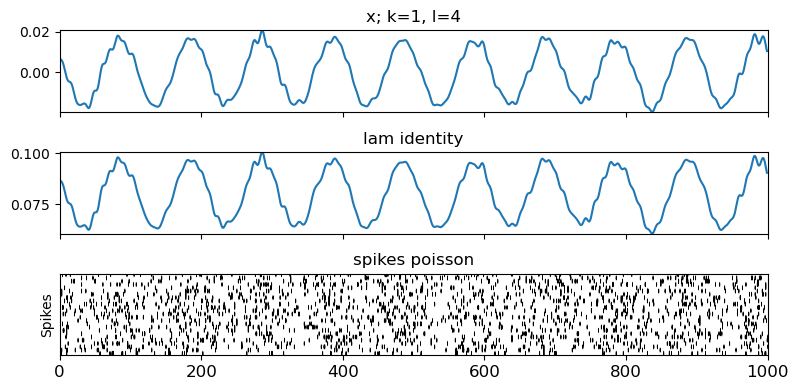

In [120]:
k = 1
l = 0
for l in range(5):
    fig, ax = plt.subplots(3,1,figsize=(8,4), sharex=True)
    ax[0].plot(xs[l,k,:])
    ax[0].set_title(f'x; k={k}, l={l}')
    ax[1].plot(lams_idlink[l,k,:])
    ax[1].set_title(f'lam identity')
    draw_raster_single(spikes_poisson[l,:,k,:], trange=[0,1000], ax = ax[2])
    ax[2].set_title(f'spikes poisson')
    ax[0].margins(0)
    ax[1].margins(0)

    plt.tight_layout()

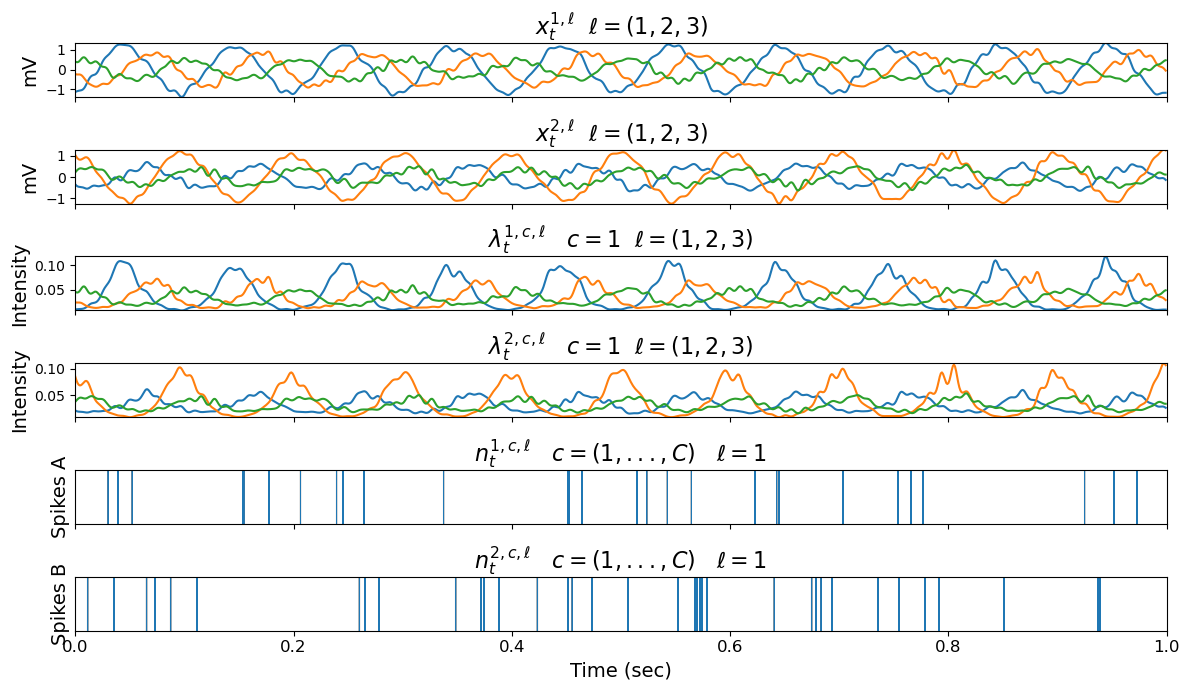

In [9]:
alpha = -3.5
K = 2
L = 25 
C = 1
sample_length = 1000
seed = 7
plot_synthetic_data(L, sample_length, C, seed, alpha, 
start=3)



In [4]:
data_path = f'../sgc/saved/synthetic_data/simple_synthetic_nodc_2_{L}_{sample_length}_25_-3.5_7'
data_load = pickle_open(data_path)
Gamma = data_load['latent']['Gamma']
freqs = data_load['meta']['freqs']

/scratch/252165.1.ood/ipykernel_2999115/4282160142.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freqs, 10*np.log10(Gamma[:,0,0].real))


(0.0, 50.0)

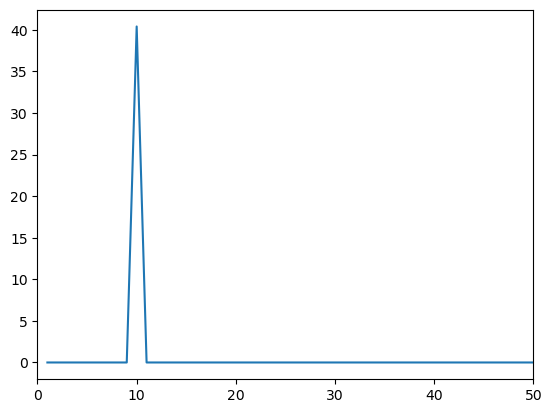

In [5]:
# plt.plot(freqs, Gamma[:,0,0].real)
plt.plot(freqs, 10*np.log10(Gamma[:,0,0].real))
plt.xlim([0,50])

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.plot import draw_raster_single
alpha = -3.0
L = 25 
C = 10
sample_length = 1000
seed = 8
k = 2
# prev_model = model_load

In [7]:
num_em=10

## Want to alter Gamma so values of xs appropriate for identity link 

In [90]:
data_path = f'saved/synthetic_data/simple_synthetic_nodc_2_{L}_{sample_length}_1_-3.5_7'
C = 25
alpha = -2.0
model_path = f'saved/fitted_models/simple_synthetic_nodc_em{num_em}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_fitted'

data_load = pickle_open(data_path)
model_load = pickle_open(model_path)

spikes = data_load['observed']['spikes']
lams = data_load['observed']['lams']
Gamma_true = data_load['latent']['Gamma']
xs = data_load['latent']['xs']
vs = data_load['latent']['vs']
zs = data_load['latent']['zs']
Wv_data = data_load['meta']['Wv']
freqs = data_load['meta']['freqs']

Wv_model = model_load['Wv']
Wv = Wv_model
freqs_mod = freqs[:int((Wv.shape[1]) / 2)]

freqs_dc = np.repeat(freqs_mod,2)
freqs_dc = np.insert(freqs_dc, 0, 0)
J = int((Wv.shape[1])/2)

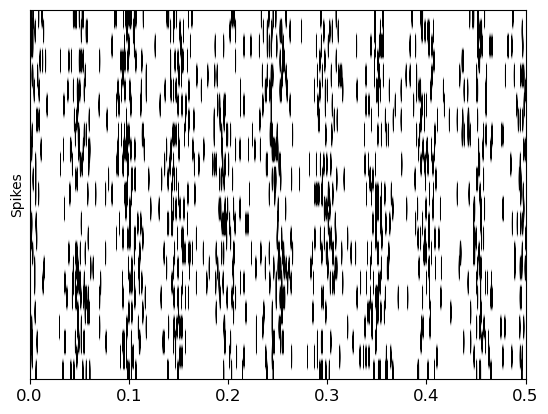

In [14]:
draw_raster_single(spikes[0,:,0,:])
# spikes.shape

In [91]:
from cohlib.utils import conv_v_to_z
def Gamma_est_from_zs(zs, dc=False):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean

zs_ests = Gamma_est_from_zs(zs)

zvs = conv_v_to_z(vs, axis=2,dc=False)
Gamma_est_zv = Gamma_est_from_zs(zvs, dc=False)
np.all(np.isclose(zs, zvs))

True

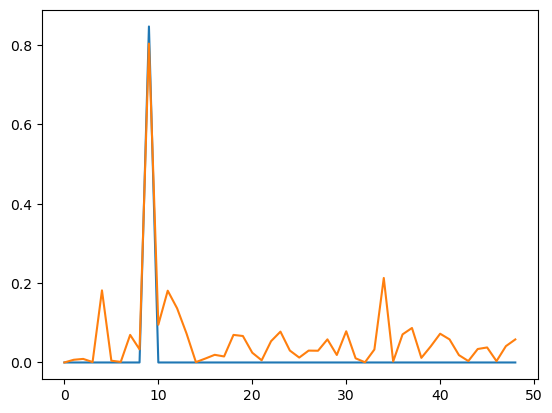

In [92]:
from cohlib.estimation import thr_coherence
plt.plot(thr_coherence(Gamma_true[:49,:,:]))
plt.plot(thr_coherence(Gamma_est_zv[:49,:,:]))

In [18]:
K = 2
from cohlib.alg.em_sgc import transform_cov_c2r, reverse_rearrange_mat
# Gamma_true_inv_real_k_ord = np.stack([reverse_rearrange_mat(Gamma_true_inv_real_ri_ord[j,:,:], K) for j in range(J)])
Gamma_true_real_ri_ord = np.stack([transform_cov_c2r(Gamma_true[j,:,:]) for j in range(J)])
Gamma_true_real_k_ord = np.stack([reverse_rearrange_mat(Gamma_true_real_ri_ord[j,:,:], K) for j in range(J)])
dets_c = np.array([np.linalg.det(Gamma_true[j,:,:]) for j in range(J)])
dets_r = np.array([np.linalg.det(Gamma_true_real_ri_ord[j,:,:]) for j in range(J)])

In [19]:
K = 2
dets_c = np.array([np.linalg.det(Gamma_true[j,:,:]) for j in range(J)])
dets_r = np.array([np.linalg.det(Gamma_true_real_ri_ord[j,:,:]) for j in range(J)])
dets_r2 = np.array([np.linalg.det(Gamma_true_real_k_ord[j,:,:]) for j in range(J)])
np.all(np.isclose(dets_r, dets_r2))

True

(0.0, 100.0)

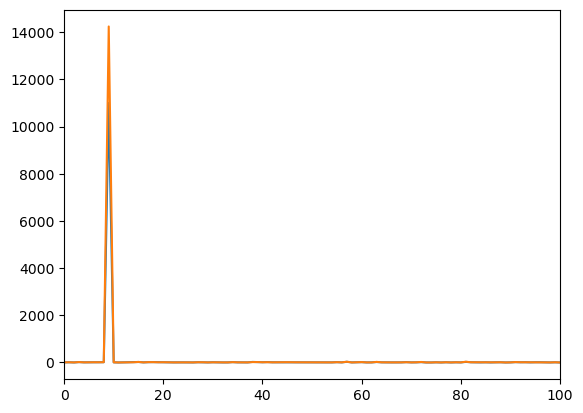

In [20]:
true_S1 = Gamma_true[:,0,0].real
dir_est_S1 = Gamma_est_zv[:,0,0].real
plt.plot(true_S1)
plt.plot(dir_est_S1)
plt.xlim([0,100])

In [21]:
def Gamma_full_real_to_Gamma_real(Gamma_full_real, K, num_J_vars, DC=True):
    if DC is True:
        DC = np.zeros((K,K))
        base_filt = np.zeros(num_J_vars)
        base_filt[0] = 1
        j_filt = np.tile(base_filt.astype(bool), K)

        for k in range(K):
            DC[:,k] = Gamma_full_real[j_filt,k*num_J_vars]

        Gamma_reduced_real = np.zeros((J, 2*K, 2*K))
        base_filt = np.zeros(num_J_vars)

        for j in range(J):
            j_var = int(j*2 + 1)
            base_filt = np.zeros(num_J_vars)
            base_filt[j_var:j_var+2] = 1
            j_filt = np.tile(base_filt.astype(bool), K)
            # print(j_filt)

            for k in range(K):
                kj = int(k*2)
                # Gamma_full[j_filt,k*num_J_vars+j_var:k*num_J_vars+j_var+2] = Gamma_n_real[:,kj:kj+2]
                Gamma_reduced_real[j,:,kj:kj+2] = Gamma_full_real[j_filt,k*num_J_vars+j_var:k*num_J_vars+j_var+2]
        
        return DC, Gamma_reduced_real

    else: 
        raise NotImplementedError

from cohlib.utils import reverse_rearrange_mat, transform_cov_r2c
def get_g_from_realinvfull(real_inv_full, K, J):
    dc_inv, real_inv_reduced = Gamma_full_real_to_Gamma_real(real_inv_full, K, num_J_vars)
    dc = np.diag(1/np.diag(dc_inv))
    init_inv = np.stack([transform_cov_r2c(reverse_rearrange_mat(real_inv_reduced[j,:,:],K)) for j in range(J)])
    init_G = np.stack([np.linalg.inv(init_inv[j,:,:]) for j in range(J)])
    return dc, init_G

In [22]:
Gamma_inv_init = model_load['inv_init']
num_J_vars = Wv.shape[1]

In [23]:
# est = model_load['track'][r]['gamma']
len(model_load['track'])

1

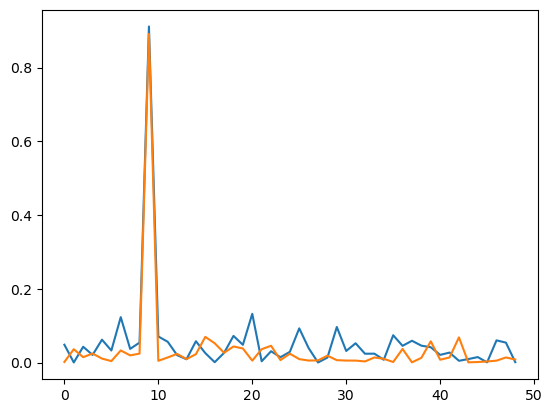

In [24]:
r = 9
m = 0
n = 0
taper = 0
coh_direst = thr_coherence(Gamma_est_zv[:49,:,:])
# dc_init, init = get_g_from_realinvfull(Gamma_inv_init, K, J)
est = model_load['track'][taper][r]['gamma']
coh_est = thr_coherence(est)
# plt.plot(Gamma_est_z[:49,m,n].real, color='blue', alpha=0.5)
# plt.plot(Gamma_est_z[:49,m,n].imag, color='blue', alpha=0.5)
plt.plot(coh_direst[:49])
plt.plot(coh_est)
# plt.plot(init[:,m,n].real)
# plt.plot(est[:,m,n].real, color='red', alpha=0.5)
# plt.plot(est[:,m,n].imag, color='red', alpha=0.5)

In [145]:
# from cohlib.alg.em_sgc import transform_cov_r2c, construct_Gamma_full_real_dc
# Gamma_true_inv = np.stack([np.linalg.inv(Gamma_true[j,:,:]) for j in range(J)])
# test_init = construct_Gamma_full_real_dc(np.diag(1/np.diag(DC_true)), Gamma_true_inv, K, num_J_vars, invert=False)
# DC, test_init_reduce = Gamma_full_real_to_Gamma_real(test_init, K, num_J_vars)
# confirm = np.stack([transform_cov_r2c(reverse_rearrange_mat(test_init_reduce[j,:,:],K)) for j in range(J)])
# np.all(Gamma_true_inv == confirm)

In [25]:
r = 9
Gamma_est = model_load['track'][taper][r]['gamma']

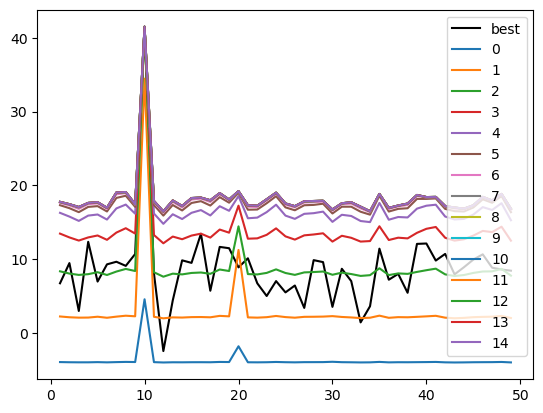

In [26]:
# plt.plot(freqs_mod, Gamma_est_zv[:49,0,0].real, color='k', label=f'best')
plt.plot(freqs_mod, 10*np.log10(Gamma_est_zv[:49,0,0].real), color='k', label=f'best')
for r in range(num_em):
    # Gamma_est = np.stack([transform_cov_r2c(model_load['track'][l]['real'][i,:,:]) for i in range(J)])
    Gamma_est = model_load['track'][taper][r]['gamma']
    # Gamma_est_prev = prev_model['track'][r]['gamma']
    cohest = thr_coherence(Gamma_est)
    # cohsample = thr_coherence(Gamma_est_z[:49,:,:])
    # plt.plot(freqs_mod, cohtrue[:49], label=f'{r}')
    # plt.plot(freqs_mod, cohest, label=f'{r}')
    # plt.plot(freqs_mod, cohsample, label=f'{r}')
    # plt.plot(freqs_mod, Gamma_est[:,0,1].imag, label=f'{r}')
    # plt.plot(freqs_mod, Gamma_est_prev[:,0,1].imag, label=f'{r}')
    # plt.plot(freqs_mod, np.abs(Gamma_est[:,0,1]), label=f'{r}')
    # plt.plot(freqs_mod, Gamma_est[:,0,0].real, label=f'{r}')
    plt.plot(freqs_mod, 10*np.log10(Gamma_est[:,0,0].real), label=f'{r}')
    # plt.plot(freqs_mod, Gamma_est_prev[:,0,0].real, label=f'{r}', color='red')
    # plt.plot(freqs_mod, Gamma_est[:,1,0].imag)
    # plt.plot(freqs, Gamma_true[:,0,1].real, color='tab:blue')
    # plt.plot(freqs, Gamma_true[:,0,1].imag, color='tab:blue')
    # plt.xlim([0,60])
    # plt.ylim([0,6000])
plt.legend()

In [75]:
g = model_load['track'][r]['gamma']
g.shape

(49, 2, 2)

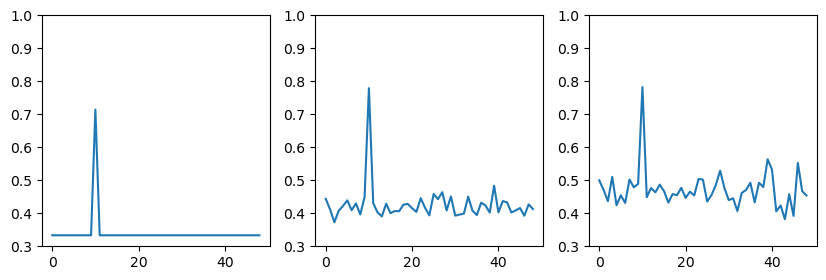

In [208]:
Gamma_est_model = model_load['track'][9]['gamma']
fig, ax = plt.subplots(1,3, figsize=(10,3))
coh_model = get_globalcoh(Gamma_est_model)
coh_z = get_globalcoh(Gamma_est_z[:49,:,:])
coh_true = get_globalcoh(Gamma_true[:49,:,:])
ax[0].plot(coh_true)
ax[1].plot(coh_model)
ax[2].plot(coh_z)
for i in range(3):
    ax[i].set_ylim([.3,1])

In [ ]:
#

In [41]:
from cohlib.utils import logistic

In [56]:
y = model_load['track'][9]['inv']
np.linalg.det(y)

0.0

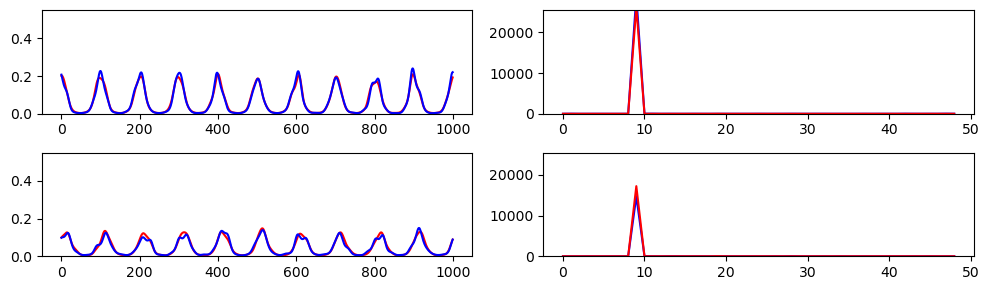

In [47]:
r = 2
l = 13
fig, ax = plt.subplots(2,2, figsize=(10,3))
mus = model_load['track'][r]['mus']
# mus = prev_model['track'][r]['mus']
mul = mus[l,:].reshape(2,-1)
vl = vs[l,:,:99].reshape(2,-1)
ax[0,0].plot(logistic(Wv @ mul[0,:]), color='red')
ax[0,0].plot(logistic(Wv @ vl[0,:]), color='blue')
ax[1,0].plot(logistic(Wv @ mul[1,:]), color='red')
ax[1,0].plot(logistic(Wv @ vl[1,:]), color='blue')
ax[1,0].set_ylim([0,0.55])
ax[0,0].set_ylim([0,0.55])

mulz = conv_v_to_z(mul, axis=1)
vlz = conv_v_to_z(vl, axis=1)
ax[0,1].plot(np.abs(vlz[0,1:])**2, color='blue')
ax[0,1].plot(np.abs(mulz[0,1:])**2, color='red')
ax[1,1].plot(np.abs(vlz[1,1:])**2, color='blue')
ax[1,1].plot(np.abs(mulz[1,1:])**2, color='red')
ax[0,1].set_ylim([0,25500])
ax[1,1].set_ylim([0,25500])
plt.tight_layout()

In [105]:
ginv = model_load['track'][3]['inv'] + np.eye(198)*1.0
np.diag(ginv).max()

1.742086143773005

In [106]:
np.log(2*np.pi*np.linalg.det(np.linalg.inv(ginv)))

-5.131739546749414

In [115]:
ginv = model_load['track'][0]['gamma'] 

In [116]:
prior = np.eye(2) + 0*1j*np.eye(2)
gupdate = ginv + prior[None,:,:]

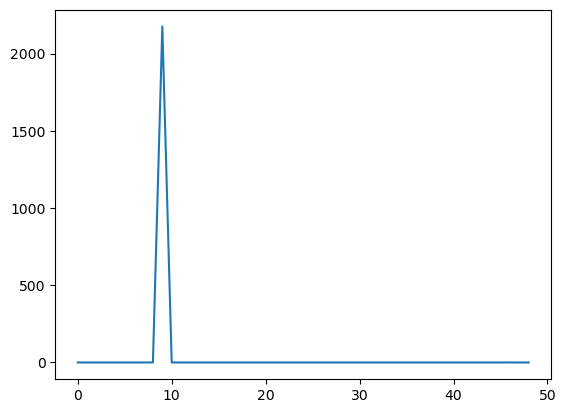

In [118]:
plt.plot(gupdate[:,0,1].real)

In [108]:
ginv.shape + 

(49, 2, 2)

(0.0, 50.0)

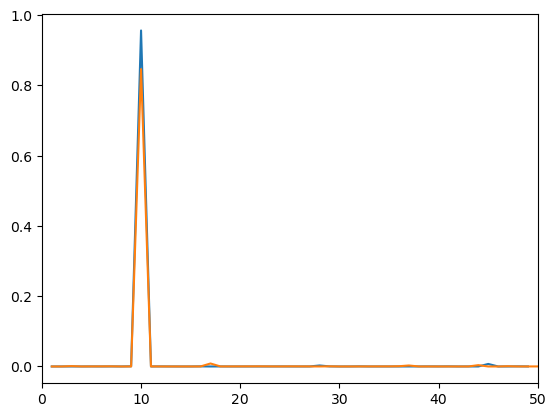

In [282]:
plt.plot(freqs_mod,cohest)
plt.plot(freqs,cohtrue)
plt.xlim([0,50])

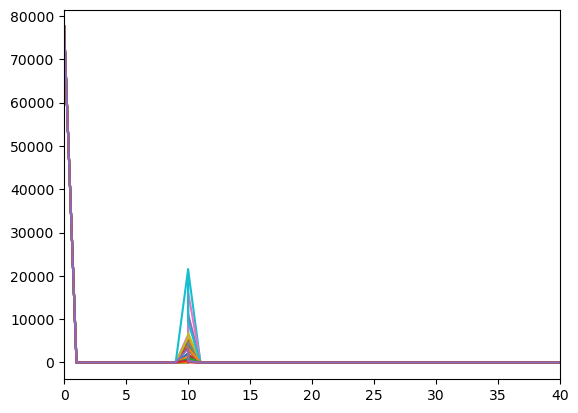

In [21]:
for l in range(L):
    plt.plot(freqs_dc, vs[l,1,:-2]**2)
    plt.xlim([0,40])

In [93]:
zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,:], zs[:,:,:].conj())
zs_outer_mean = zs_outer.mean(3)
vs_outer = np.einsum('ijk,imk->kjmi', vs[:,:,:], vs[:,:,:].conj())
vs_outer_mean = vs_outer.mean(3)

In [226]:
from cohlib.utils import conv_v_to_z, conv_z_to_v
import numpy as np
from numpy.fft import rfft
zf_x = rfft(xs, axis=2)
v_x = np.apply_along_axis(lambda x: Wv.T @ x, 2, xs)
z_x = conv_v_to_z(v_x, axis=2, dc=True)
v_x2 = conv_z_to_v(z_x, axis=2, dc=True)

In [65]:
J = int(sample_length/2)
J

500

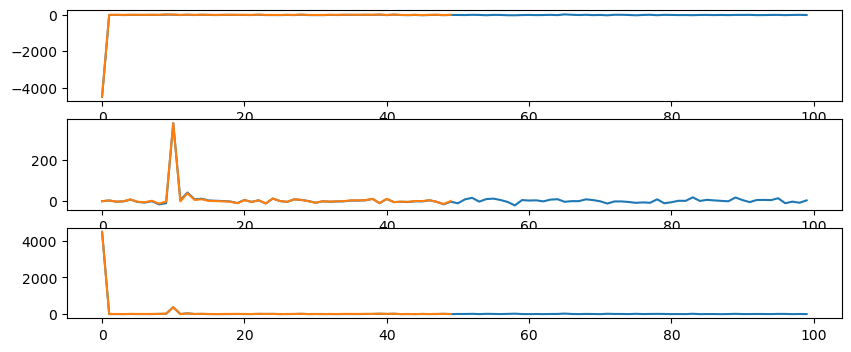

In [227]:
l = 3
k = 0
scalez = sample_length/(2*np.pi)
# plt.plot(z_x[l,k,1:].real)
fig, ax = plt.subplots(3,1,figsize=(10,4))
ax[0].plot(zf_x[l,k,0:100].real) 
ax[0].plot(scalez*z_x[l,k,0:100].real)

ax[1].plot(zf_x[l,k,0:100].imag) 
ax[1].plot(scalez*z_x[l,k,0:100].imag)

ax[2].plot(np.abs(zf_x[l,k,0:100])) 
ax[2].plot(np.abs(scalez*z_x[l,k,0:100]))

In [228]:
z_x_outer = np.einsum('ijk,imk->kjmi', z_x[:,:,1:], z_x[:,:,1:].conj())
z_x_outer_mean = z_x_outer.mean(3)

zf_x_outer = np.einsum('ijk,imk->kjmi', zf_x[:,:,1:], zf_x[:,:,1:].conj())
zf_x_outer_mean = zf_x_outer.mean(3)

In [229]:
spikes_mean = spikes.mean(1)
spikes_mean.shape

(25, 2, 1000)

In [237]:
import numpy as np
# v_spikes_c = np.apply_along_axis(lambda x: Wv.T @ x, 3, spikes)
v_spikes_c = np.apply_along_axis(lambda x: Wv_pinv @ x, 3, spikes)

In [238]:
v_spikes = v_spikes_c.mean(1)

In [239]:
from cohlib.utils import conv_v_to_z
z_spikes = conv_v_to_z(v_spikes, axis=2, dc=True)

In [240]:
# z_spikes_outer = np.einsum('ijk,imk->kjmi', scalez*z_spikes[:,:,1:], scalez*z_spikes[:,:,1:].conj())
z_spikes_outer = np.einsum('ijk,imk->kjmi', z_spikes[:,:,1:], z_spikes[:,:,1:].conj())
z_spikes_outer.shape
outer_mean = z_spikes_outer.mean(3)

In [241]:
from cohlib.estimation import thr_coherence

test = thr_coherence(outer_mean, mag_sq=True)

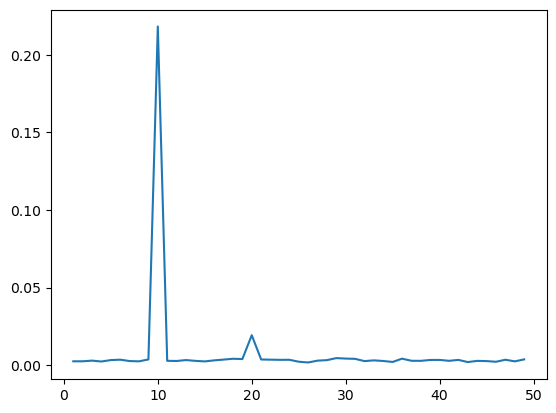

In [244]:
test = thr_coherence(outer_mean, mag_sq=True)
plt.plot(freqs[:49], outer_mean[:,0,0].real)
# plt.plot(freqs[:49], test)
# plt.xlim([0,90])

In [78]:
# Gamma_true = data_load['latent']['Gamma']
data_load['latent'].keys()

dict_keys(['Gamma', 'xs', 'vs', 'zs'])

In [79]:
from cohlib.utils import get_dcval
get_dcval(-5.0, 250)

-99.47183943243459

(0.0, 50.0)

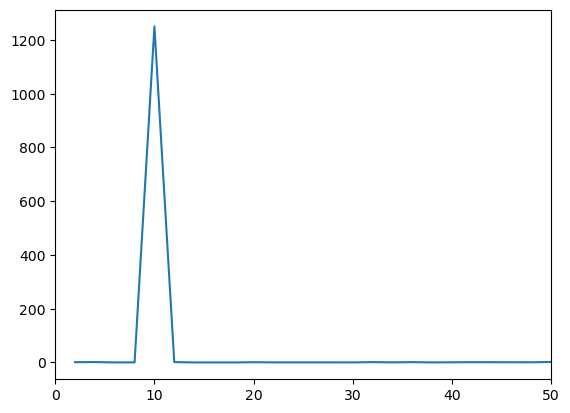

In [45]:
plt.plot(freqs, Gamma_true[:,1,1].real)
plt.xlim([0,50])

(0.0, 50.0)

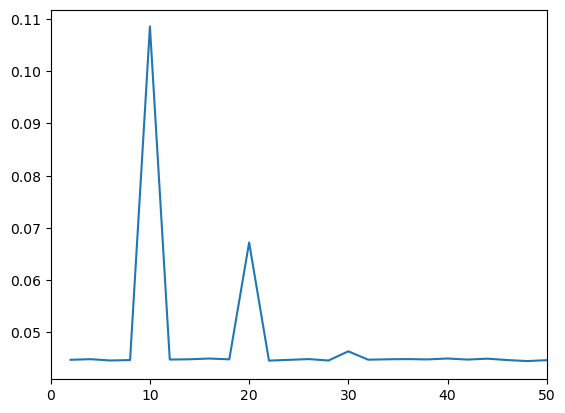

In [48]:
plt.plot(freqs, Gamma_est[:,0,0].real)
plt.xlim([0,50])

(0.0, 90.0)

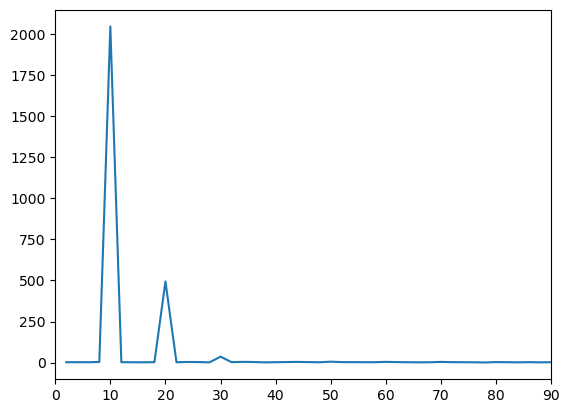

In [76]:
plt.plot(freqs, outer_mean[:,0,0].real)
plt.xlim([0,90])


In [ ]:
# let's make sure this isn't something funny about Wv

max: 0.02503065003304635
min: -0.025032610785576042
mean: -9.76994034663282e-05
start: 0.023817090947591775
end: 0.02028857653002835


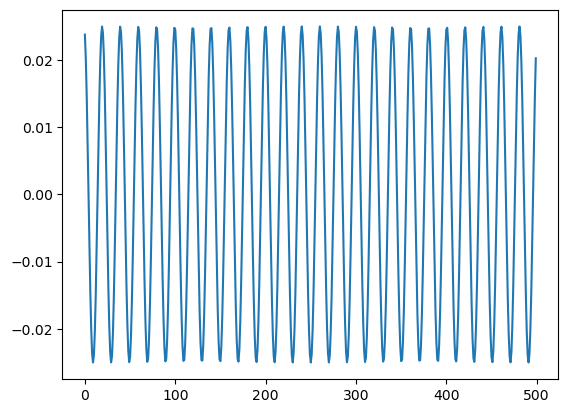

In [87]:
ind = 49
plt.plot(Wv[:,ind])
print(f'max: {np.max(Wv[:,ind])}')
print(f'min: {np.min(Wv[:,ind])}')
print(f'mean: {np.mean(Wv[:,ind])}')
print(f'start: {Wv[0,ind]}')
print(f'end: {Wv[-1,ind]}')

In [90]:
k = 0
spikes_mat = np.concatenate([spikes[w,:,:,:].swapaxes(1,2).swapaxes(0,1) for w in range(10)])
xs_mat = np.concatenate([xs[w,:,:].swapaxes(0,1) for w in range(10)])
vs_mat = np.concatenate([vs[w,:,:].swapaxes(0,1) for w in range(10)])
zs_mat = np.concatenate([zs[w,:,:].swapaxes(0,1) for w in range(10)])

In [123]:
from cohlib.alg.em_sgc import transform_cov_c2r, transform_cov_r2c
test = np.array([[4,3],[3,4]]) 
test_dummy = test + np.zeros_like(test, dtype=complex)
m1 = np.linalg.inv(test_dummy)

test_c = np.zeros_like(test, dtype=complex)
for i in range(2):
    for j in range(2):
        test_c[i,j] = conv_v_to_z(np.array([test[i,j], 0]), axis=0, dc=False)[0]

np.linalg.inv(test_c)

array([[ 1.14285714+0.j, -0.85714286+0.j],
       [-0.85714286+0.j,  1.14285714+0.j]])

In [137]:
transform_cov_r2c(np.linalg.inv(transform_cov_c2r(test_dummy))).real

array([[ 2.28571429, -1.71428571],
       [-1.71428571,  2.28571429]])

In [131]:
m1

array([[ 0.57142857+0.j, -0.42857143+0.j],
       [-0.42857143+0.j,  0.57142857+0.j]])

In [130]:
transform_cov_r2c(np.linalg.inv(transform_cov_c2r(test_dummy)))

array([[ 2.28571429+0.j, -1.71428571+0.j],
       [-1.71428571+0.j,  2.28571429+0.j]])

In [103]:
from cohlib.utils import conv_v_to_z_vec
c = conv_v_to_z_vec(np.array([3,-4]), dc=False)
a,b = conv_z_to_v(np.array([c]), axis=0, dc=False)

In [106]:
test + np.zeros((2,2),dtype=complex)

array([[4.+0.j, 3.+0.j],
       [3.+0.j, 4.+0.j]])

In [89]:
data_mat = {}
data_mat['lams'] = data_load['observed']['lams']
data_mat['mu'] = data_load['observed']['mu']
data_mat['Gamma'] = data_load['latent']['Gamma']

data_mat['spikes'] = spikes_mat
data_mat['xs'] = xs_mat
data_mat['vs'] = vs_mat
data_mat['zs'] = zs_mat
# data_mat['spikes'] = data_load['observed']['spikes']
# data_mat['xs'] = data_load['latent']['xs']
# data_mat['vs'] = data_load['latent']['vs']
# data_mat['zs'] = data_load['latent']['zs']

import scipy
scipy.io.savemat('synth_data.mat', data_mat)

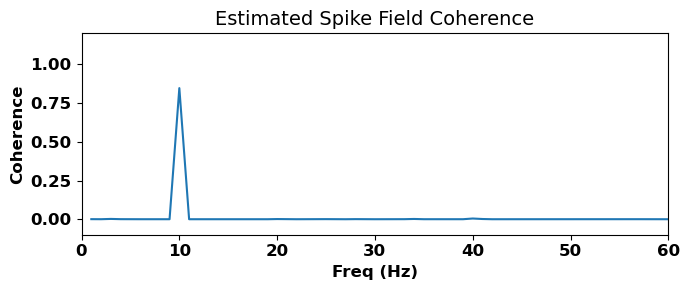

In [29]:
from matplotlib import rc
# rc('font',**{'family':'serif','serif':'Arial'})

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


label_size = 12
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(freqs, true_coh)
# lb = coh - coh_se*1.96
# ub = coh + coh_se*1.96
# ax.fill_between(freqs, lb, ub, color='tab:blue', alpha=0.5)
# ax.plot(lb)
# ax.plot(ub)
ax.set_xlim([0,60])
ax.set_ylim([-0.1,1.2])
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
# ax.set_xticklabels([0,1,5], color='white')
# ax.set_xticklabels([0,1,5])
ax.set_xlabel('Freq (Hz)', size=label_size)
ax.set_ylabel('Coherence', size=label_size)
ax.set_title('Estimated Spike Field Coherence', size=label_size+2)
plt.tight_layout()

save_path = f'saved/figures/true_coh_simple_synthetic_{L}_{sample_length}_{C}_{mu}_{snu}_{seed}.png'
plt.savefig(save_path,dpi=300)

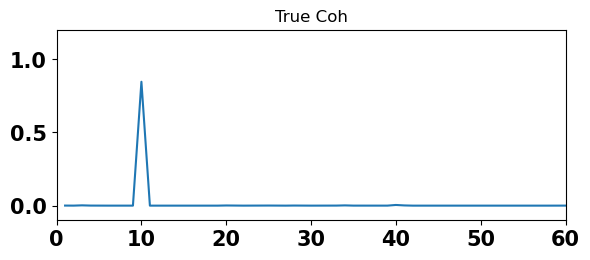

In [26]:
G
from matplotlib import rc
# rc('font',**{'family':'serif','serif':'Arial'})

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


label_size = 12
fig, ax = plt.subplots(figsize=(6,2.5))
ax.plot(freqs, true_coh)
# lb = coh - coh_se*1.96
# ub = coh + coh_se*1.96
# ax.fill_between(freqs, lb, ub, color='tab:blue', alpha=0.5)
# ax.plot(lb)
# ax.plot(ub)
ax.set_xlim([0,60])
ax.set_ylim([-0.1,1.2])
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
# ax.set_xticklabels([0,1,5], color='white')
# ax.set_xticklabels([0,1,5])
# ax.set_xlabel('Freq (Hz)', size=label_size)
# ax.set_ylabel('Coherence', size=label_size)
plt.tight_layout()
plt.title('True Coh')
plt.savefig('saved/figures/true_coh.png')

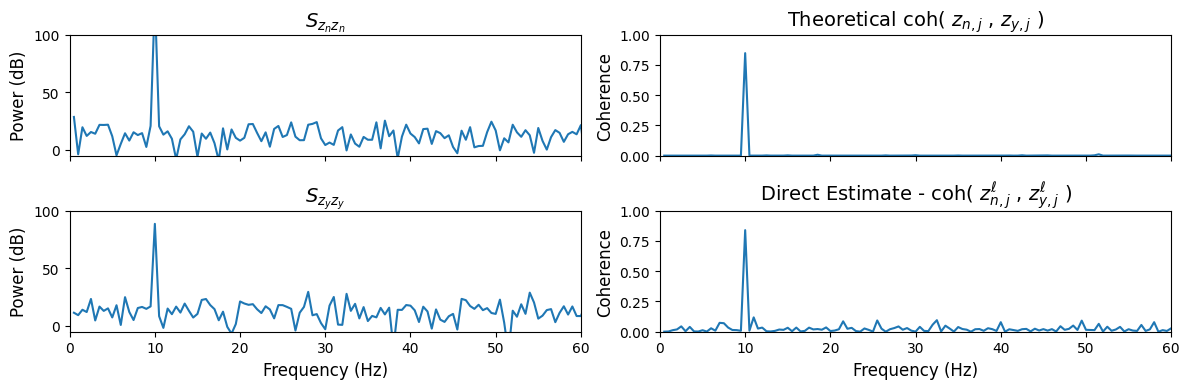

In [7]:
Sxn = (xnfs*xnfs.conj()).mean(0).real
Sxy = (xyfs*xyfs.conj()).mean(0).real
title_size = 14
label_size = 12

fig,ax = plt.subplots(2,2, figsize=(12,4), sharex=True)
lim = [0,60]
# ax[0,0].plot(freqs, 10*np.log10(Sxn))
ax[0,0].plot(freqs, 10*np.log(Gamma[:,0,0]).real)
# 10*np.log(Gamma[z_ind,0,0])
ax[0,0].set_xlim(lim)
ax[0,0].set_title(r'$S_{z_n z_n}$', size=title_size)
ax[0,0].set_ylabel('Power (dB)', size=label_size)
ax[0,0].set_ylim([-5,100])

# ax[1,0].plot(freqs, 10*np.log10(Sxy))
ax[1,0].plot(freqs, 10*np.log(Gamma[:,1,1]).real)
ax[1,0].set_xlim(lim)
ax[1,0].set_title(r'$S_{z_y z_y}$', size=title_size)
ax[1,0].set_ylim([0,50])
ax[1,0].set_ylabel('Power (dB)', size=label_size)
ax[1,0].set_xlabel('Frequency (Hz)', size=label_size)
ax[1,0].set_ylim([-5,100])

ax[1,1].plot(freqs, coh1)
ax[1,1].set_xlim(lim)
# ax[0,1].set_title(r'Direct Estimate coh est')
ax[1,1].set_title(r'Direct Estimate - coh( $z^{\ell}_{n,j}$ , $z^{\ell}_{y,j}$ )', size=title_size)
ax[1,1].set_ylim([0,1])
ax[1,1].set_ylabel('Coherence', size=label_size)
ax[1,1].set_xlabel('Frequency (Hz)', size=label_size)

ax[0,1].plot(freqs, true_coh)
ax[0,1].set_xlim(lim)
ax[0,1].set_title(r'Theoretical coh( $z_{n,j}$ , $z_{y,j}$ )', size=title_size)
ax[0,1].set_ylim([0,1])
ax[0,1].set_ylabel('Coherence', size=label_size)


plt.tight_layout()
plt.savefig('distribution.png', dpi=300)

In [9]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':'Arial'})

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

/tmp/user/1001/ipykernel_13595/3561883722.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,1,5], color='white')


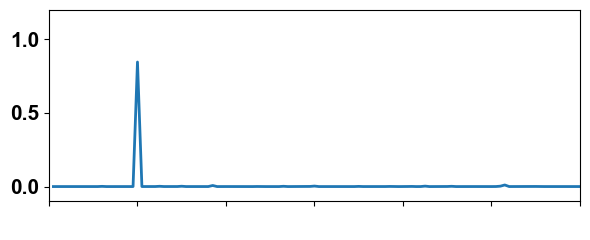

In [61]:
label_size = 12
fig, ax = plt.subplots(figsize=(6,2.5))
ax.plot(freqs, true_coh, linewidth=2 )
# ax.plot(freqs, true_coh)
# ax.plot(lb)
# ax.plot(ub)
ax.set_xlim([0,60])
ax.set_ylim([-0.1,1.2])
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15) 
ax.set_xticklabels([0,1,5], color='white')
plt.tight_layout()
plt.savefig('theoretical_coh_noxlab.pdf')



In [39]:
ind10 = np.where(freqs==10)[0]

Text(0, 0.5, 'Coherence')

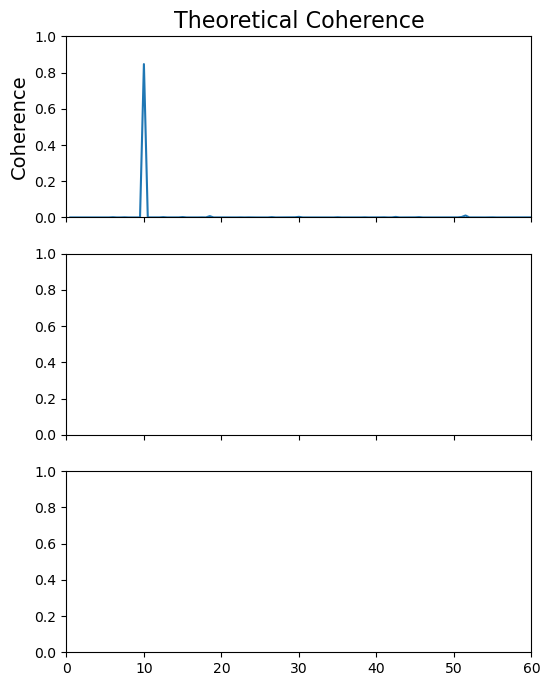

In [41]:
fig, ax = plt.subplots(3,1, figsize=(6,8), sharex=True)
tru_test = thr_coherence(Gamma)
title_size = 16
label_size = 14
# ax[0].plot(freqs[1:], tru_test)
ax[0].plot(freqs, tru_test)
ax[0].set_xlim([0,60])
ax[0].set_ylim([0,1])
ax[0].set_title(r'Theoretical Coherence', size=title_size)
ax[0].set_ylabel('Coherence', size=label_size)

In [ ]:
mus = model_load['track'][4]['mus']
musz = conv_v_to_z(mus.reshape(L,K,-1), axis=2)
vsz = conv_v_to_z(vs, axis=2)
mus_est = Gamma_est_from_zs(musz)
vs_est = Gamma_est_from_zs(vsz)
zs_est = Gamma_est_from_zs(zs)
# Gamma_true / mus_est[9,:,:]

In [103]:
def est_g_from_vs_naive(vs):
    L = vs.shape[0]
    K = vs.shape[1]
    J = int((vs.shape[2] - 1)/2)
    num_J_vars = vs.shape[2]
    from cohlib.alg.em_sgc import get_freq_vecs_real_dc, est_cov_r2c, rearrange_mat
    vs_like_mus = np.stack([np.concatenate([vs[l,0,:num_J_vars], vs[l,1,:num_J_vars]]) for l in range(L)]) 
    vs_outer = np.zeros((L, J,2*K,2*K))

    for l in range(L):
        v_js = get_freq_vecs_real_dc(vs_like_mus[l,:], K,num_J_vars)
        for j in range(J):
            vs_outer[l,j,:,:] = np.outer(v_js[j+1], v_js[j+1])

    k_mask_pre = 1 - np.eye(2)
    k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
    k_mask =  1 - k_mask_inv

    v_est_complex = np.zeros((J,K,K), dtype=complex)
    for l in range(L):
        # DC = DC_mus_outer[l,:,:] + DC_Upss[l,:,:]
        Sig_real = vs_outer[l,:,:,:]*k_mask 
        Sig_complex = np.zeros((J,K,K), dtype=complex)

        for j in range(J):
            Sig_complex[j,:,:] = est_cov_r2c(rearrange_mat(Sig_real[j,:,:],K))

        v_est_complex += Sig_complex

    v_est_complex = v_est_complex / L

    return v_est_complex, vs_outer

In [117]:
mustemp = mus.reshape(L,2,-1)
mus_naive, mus_outer = est_g_from_vs_naive(mustemp)
k_mask_pre = 1 - np.eye(2)
k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
k_mask =  1 - k_mask_inv
mus_real_mean = mus_outer.mean(0)
# np.round(mus_naive[9,:,:],5)
mus_real_est = np.stack([transform_cov_r2c(rearrange_mat(np.round(mus_real_mean[j,:,:]*k_mask,5),K)) for j in range(J)])

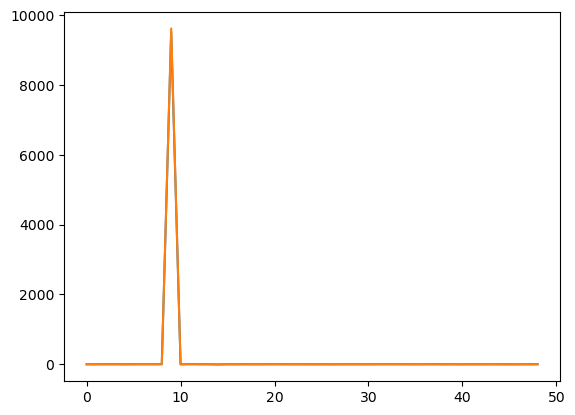

In [130]:
cohmus = thr_coherence(mus_real_est)
plt.plot(Gamma_est_z[:49,0,1].imag)
plt.plot(mus_real_est[:,0,1].imag)
# plt.plot(cohmus)

In [104]:
vs_naive, vs_outer = est_g_from_vs_naive(vs[:,:,:99])

In [107]:
from cohlib.alg.em_sgc import transform_cov_c2r, rearrange_mat
k_mask_pre = 1 - np.eye(2)
k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
k_mask =  1 - k_mask_inv
vs_real_mean = vs_outer.mean(0)
# np.round(vs_naive[9,:,:],5)
vs_real_est = np.stack([transform_cov_r2c(rearrange_mat(np.round(vs_real_mean[j,:,:]*k_mask,5),K)) for j in range(J)])
# transform_cov_r2c(np.round(vs_real_est[9,:,:]*k_mask,5))

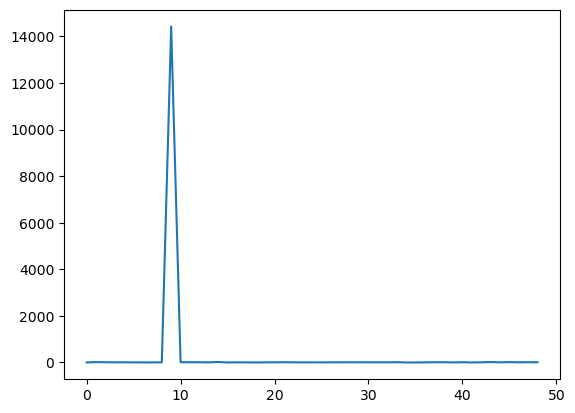

In [111]:
plt.plot(vs_real_est[:,0,0].real)

In [ ]:
j = 4
np.isclose(vs_real_est[j,:,:]/4, zs_est[j,:,:])

array([[ True,  True],
       [ True,  True]])

In [ ]:
vs_naive[9,:,:]

array([[5107.6226861    +0.j        , 4430.87520616-1498.61089065j],
       [4430.87520616+1498.61089065j, 5166.64321579   +0.j        ]])

In [ ]:
j = 1
vs_naive[j,:,:] / zs_est[j,:,:]

array([[4.+0.j, 4.-0.j],
       [4.-0.j, 4.+0.j]])

In [ ]:
temp[1:].reshape(-1,2)

array([[2, 3],
       [4, 5],
       [6, 7]])

In [ ]:
# from cohlib.utils import conv_v_to_z_vec, conv_z_to_v_vec
temp = np.array([1,2,3,4,5,6,7])
# temp_mod = temp.reshape(-1,2)
# temp_z = temp_mod[:,0] + temp_mod[:,1]*1j
# temp_z
def conv_v_to_z_vec(v, dc=True):
    if dc is True:
        J = int((v.size - 1)/2)
        z = np.zeros(J + 1, dtype=complex)
        z[0] = v[0]
        v_temp = v[1:].reshape(-1,2) 
        temp_z = v_temp[:,0] + v_temp[:,1]*1j
        z[1:] = temp_z
    else: 
        z = np.zeros(J, dtype=complex)
        v_temp = v.reshape(-1,2) 
        temp_z = v_temp[:,0] + v_temp[:,1]*1j
        z = temp_z
    return z
temp_z = conv_v_to_z_vec(temp)

In [ ]:
def conv_z_to_v_vec(z, dc=True):
    if dc is True:
        J = z.size - 1
        v = np.zeros(2*J + 1)
        v[0] = z[0].real
        v[1:] = np.array([z[1:].real, z[1:].imag]).T.reshape(J*2) 
    else:
        v = np.array([z.real, z.imag]).T.reshape(J*2) 
    return v
Jtemp = 3
# temp_z
# np.array([temp_z[1:].real, temp_z[1:].imag]).T.reshape(Jtemp*2)
conv_z_to_v_vec(temp_z)

array([1., 2., 3., 4., 5., 6., 7.])

In [ ]:
def Gamma_est_from_zs(zs, dc=True):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean

In [ ]:
vs_est[9,:,:] / mus_est[9,:,:]

array([[3.0801188 +0.j        , 2.80141472+0.02669605j],
       [2.80141472-0.02669605j, 3.071161  +0.j        ]])

In [ ]:
print(Gamma_true[9,:,:])
print(zs_est[9,:,:])
print(vs_est[9,:,:])
print(mus_est[9,:,:])

[[1500.          +0.j         1271.62015167-536.08039496j]
 [1271.62015167+536.08039496j 1500.          +0.j        ]]
[[1276.90567152  +0.j         1107.71880154-374.65272266j]
 [1107.71880154+374.65272266j 1291.66080395  +0.j        ]]
[[1276.90567152  +0.j         1107.71880154-374.65272266j]
 [1107.71880154+374.65272266j 1291.66080395  +0.j        ]]
[[0.03941621+0.j         0.03373712-0.01160041j]
 [0.03373712+0.01160041j 0.04047712+0.j        ]]


/projectnb/stephenlab/jtauber/cohlib/cohlib/estimation.py:54: RuntimeWarning: invalid value encountered in divide
  t_coh = num/denom


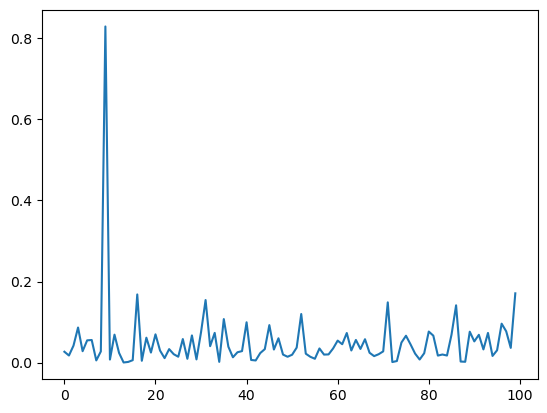

In [ ]:
cohmus = thr_coherence(mus_est)
plt.plot(cohmus)

In [ ]:
mus_est[9,:,:]*2

array([[0.07883242+0.j        , 0.06747423-0.02320082j],
       [0.06747423+0.02320082j, 0.08095424+0.j        ]])